# Part 1

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType, DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, DecisionTreeClassifier, GBTClassifier,\
MultilayerPerceptronClassifier, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("workclass", StringType(), True),
    StructField("fnlwgt", DoubleType(), True),
    StructField("education", StringType(), True),
    StructField("education_num", DoubleType(), True),
    StructField("marital_status", StringType(), True),
    StructField("occupation", StringType(), True),        
    StructField("relationship", StringType(), True),
    StructField("race", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("capital_gain", DoubleType(), True),
    StructField("capital_loss", DoubleType(), True),
    StructField("hours_per_week", DoubleType(), True),
    StructField("native_country", StringType(), True),
    StructField("income", StringType(), True),
])

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/21 19:37:23 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/10/21 19:37:23 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/10/21 19:37:23 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/10/21 19:37:24 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


1. Data loading

In [2]:
df = spark.read.option("inferSchema", "True").schema(Schema).csv("gs://dataproc-staging-us-east1-882795771611-ccxr9twc/notebooks/jupyter/HW2/adult.data.csv")
df.take(3)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



2. Data preprocessing

In [3]:
indexer = StringIndexer(inputCols=["workclass", "education", "marital_status",\
                                   "occupation", "relationship", "race", "sex",\
                                  "native_country"],\
                        outputCols=["workclassIndex", "educationIndex", "marital_statusIndex",\
                                   "occupationIndex", "relationshipIndex", "raceIndex", "sexIndex",\
                                  "native_countryIndex"])
# indexed = indexer.fit(df).transform(df)

In [4]:
encoder = OneHotEncoder(inputCols=["workclassIndex", "educationIndex", "marital_statusIndex",\
                                   "occupationIndex", "relationshipIndex", "raceIndex", "sexIndex",\
                                  "native_countryIndex"],
                        outputCols=["workclassVec", "educationVec", "marital_statusVec",\
                                   "occupationVec", "relationshipVec", "raceVec", "sexVec",\
                                  "native_countryVec"])
# encoded = encoder.fit(indexed).transform(indexed)

In [5]:
assembler = VectorAssembler(
    inputCols=["age", "fnlwgt", "education_num", "capital_gain", "capital_loss",\
               "hours_per_week", "workclassVec", "educationVec", "marital_statusVec",\
               "occupationVec", "relationshipVec", "raceVec", "sexVec",\
              "native_countryVec"],
    outputCol="features")
# output = assembler.transform(encoded)

In [6]:
labelGenerater = StringIndexer(inputCols=["income"],\
                        outputCols=["label"])
# preprossed = labelGenerater.fit(output).transform(output)

In [7]:
dataPreprocess = Pipeline(stages=[indexer, encoder, assembler, labelGenerater])
df = dataPreprocess.fit(df).transform(df)
df.printSchema()
training, test = df.randomSplit([0.7, 0.3], seed=100)
print(training.count())
print(test.count())

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- workclassIndex: double (nullable = false)
 |-- educationIndex: double (nullable = false)
 |-- marital_statusIndex: double (nullable = false)
 |-- occupationIndex: double (nullable = false)
 |-- relationshipIndex: double (nullable = false)
 |-- raceIndex: double (nullable = false)
 |-- sexIndex: double (nullable = false)
 |-- native_countryIndex: double (nullable = f

22/10/21 19:37:47 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


22832


9729


3. Modeling

In [8]:
modelAccuracy = {}

In [9]:
lr = LogisticRegression(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[lr])
model = pipeline.fit(training)
predictions = model.transform(test)
predictions.groupby("prediction").count().show()
predictions.show()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

modelAccuracy["LogisticRegression"] = accuracy
print(f"Test set accuracy = {accuracy}")

22/10/21 19:37:56 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/21 19:37:56 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 7812|
|       1.0| 1917|
+----------+-----+



+---+---------+--------+-------------+-------------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+----------------+------+--------------+--------------+-------------------+---------------+-----------------+---------+--------+-------------------+-------------+--------------+-----------------+--------------+---------------+-------------+-------------+-----------------+--------------------+-----+--------------------+--------------------+----------+
|age|workclass|  fnlwgt|    education|education_num|marital_status|occupation|   relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|  native_country|income|workclassIndex|educationIndex|marital_statusIndex|occupationIndex|relationshipIndex|raceIndex|sexIndex|native_countryIndex| workclassVec|  educationVec|marital_statusVec| occupationVec|relationshipVec|      raceVec|       sexVec|native_countryVec|            features|label|       rawPrediction|   

Test set accuracy = 0.8501387604070305


In [10]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(training)
predictions = model.transform(test)
predictions.groupby("prediction").count().show()
predictions.show()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

modelAccuracy["RandomForestClassifier"] = accuracy
print(f"Test set accuracy = {accuracy}")

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 9016|
|       1.0|  713|
+----------+-----+



+---+---------+--------+-------------+-------------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+----------------+------+--------------+--------------+-------------------+---------------+-----------------+---------+--------+-------------------+-------------+--------------+-----------------+--------------+---------------+-------------+-------------+-----------------+--------------------+-----+--------------------+--------------------+----------+
|age|workclass|  fnlwgt|    education|education_num|marital_status|occupation|   relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|  native_country|income|workclassIndex|educationIndex|marital_statusIndex|occupationIndex|relationshipIndex|raceIndex|sexIndex|native_countryIndex| workclassVec|  educationVec|marital_statusVec| occupationVec|relationshipVec|      raceVec|       sexVec|native_countryVec|            features|label|       rawPrediction|   

Test set accuracy = 0.8114914174118615


In [11]:
nb = NaiveBayes(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[nb])
model = pipeline.fit(training)
predictions = model.transform(test)
predictions.groupby("prediction").count().show()
predictions.show()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

modelAccuracy["NaiveBayes"] = accuracy
print(f"Test set accuracy = {accuracy}")

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 8836|
|       1.0|  893|
+----------+-----+



+---+---------+--------+-------------+-------------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+----------------+------+--------------+--------------+-------------------+---------------+-----------------+---------+--------+-------------------+-------------+--------------+-----------------+--------------+---------------+-------------+-------------+-----------------+--------------------+-----+--------------------+-----------+----------+
|age|workclass|  fnlwgt|    education|education_num|marital_status|occupation|   relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|  native_country|income|workclassIndex|educationIndex|marital_statusIndex|occupationIndex|relationshipIndex|raceIndex|sexIndex|native_countryIndex| workclassVec|  educationVec|marital_statusVec| occupationVec|relationshipVec|      raceVec|       sexVec|native_countryVec|            features|label|       rawPrediction|probability|

Test set accuracy = 0.7829170521122417


In [12]:
dtc = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[dtc])
model = pipeline.fit(training)
predictions = model.transform(test)
predictions.groupby("prediction").count().show()
predictions.show()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

modelAccuracy["DecisionTreeClassifier"] = accuracy
print(f"Test set accuracy = {accuracy}")

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 8307|
|       1.0| 1422|
+----------+-----+



+---+---------+--------+-------------+-------------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+----------------+------+--------------+--------------+-------------------+---------------+-----------------+---------+--------+-------------------+-------------+--------------+-----------------+--------------+---------------+-------------+-------------+-----------------+--------------------+-----+---------------+--------------------+----------+
|age|workclass|  fnlwgt|    education|education_num|marital_status|occupation|   relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|  native_country|income|workclassIndex|educationIndex|marital_statusIndex|occupationIndex|relationshipIndex|raceIndex|sexIndex|native_countryIndex| workclassVec|  educationVec|marital_statusVec| occupationVec|relationshipVec|      raceVec|       sexVec|native_countryVec|            features|label|  rawPrediction|         prob

Test set accuracy = 0.8379072874910063


In [13]:
gbtc = GBTClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[gbtc])
model = pipeline.fit(training)
predictions = model.transform(test)
predictions.groupby("prediction").count().show()
predictions.show()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

modelAccuracy["GBTClassifier"] = accuracy
print(f"Test set accuracy = {accuracy}")

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 7972|
|       1.0| 1757|
+----------+-----+



+---+---------+--------+-------------+-------------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+----------------+------+--------------+--------------+-------------------+---------------+-----------------+---------+--------+-------------------+-------------+--------------+-----------------+--------------+---------------+-------------+-------------+-----------------+--------------------+-----+--------------------+--------------------+----------+
|age|workclass|  fnlwgt|    education|education_num|marital_status|occupation|   relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|  native_country|income|workclassIndex|educationIndex|marital_statusIndex|occupationIndex|relationshipIndex|raceIndex|sexIndex|native_countryIndex| workclassVec|  educationVec|marital_statusVec| occupationVec|relationshipVec|      raceVec|       sexVec|native_countryVec|            features|label|       rawPrediction|   

Test set accuracy = 0.8503443313804091


In [14]:
mpc = MultilayerPerceptronClassifier(layers=[100, 2, 2], seed=100)
pipeline = Pipeline(stages=[mpc])
model = pipeline.fit(training)
predictions = model.transform(test)
predictions.groupby("prediction").count().show()
predictions.show()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

modelAccuracy["MultilayerPerceptronClassifier"] = accuracy
print(f"Test set accuracy = {accuracy}")

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 9726|
|       1.0|    3|
+----------+-----+



+---+---------+--------+-------------+-------------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+----------------+------+--------------+--------------+-------------------+---------------+-----------------+---------+--------+-------------------+-------------+--------------+-----------------+--------------+---------------+-------------+-------------+-----------------+--------------------+-----+--------------------+--------------------+----------+
|age|workclass|  fnlwgt|    education|education_num|marital_status|occupation|   relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|  native_country|income|workclassIndex|educationIndex|marital_statusIndex|occupationIndex|relationshipIndex|raceIndex|sexIndex|native_countryIndex| workclassVec|  educationVec|marital_statusVec| occupationVec|relationshipVec|      raceVec|       sexVec|native_countryVec|            features|label|       rawPrediction|   

Test set accuracy = 0.7570151094665434


In [15]:
lsvc = LinearSVC(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[lsvc])
model = pipeline.fit(training)
predictions = model.transform(test)
predictions.groupby("prediction").count().show()
predictions.show()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

modelAccuracy["LinearSVC"] = accuracy
print(f"Test set accuracy = {accuracy}")

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 7911|
|       1.0| 1818|
+----------+-----+



+---+---------+--------+-------------+-------------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+----------------+------+--------------+--------------+-------------------+---------------+-----------------+---------+--------+-------------------+-------------+--------------+-----------------+--------------+---------------+-------------+-------------+-----------------+--------------------+-----+--------------------+----------+
|age|workclass|  fnlwgt|    education|education_num|marital_status|occupation|   relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|  native_country|income|workclassIndex|educationIndex|marital_statusIndex|occupationIndex|relationshipIndex|raceIndex|sexIndex|native_countryIndex| workclassVec|  educationVec|marital_statusVec| occupationVec|relationshipVec|      raceVec|       sexVec|native_countryVec|            features|label|       rawPrediction|prediction|
+---+-------

Test set accuracy = 0.8485969781066913


In [16]:
ovr = OneVsRest(labelCol="label", featuresCol="features", classifier=lr)
pipeline = Pipeline(stages=[ovr])
model = pipeline.fit(training)
predictions = model.transform(test)
predictions.groupby("prediction").count().show()
predictions.show()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

modelAccuracy["OneVsRest"] = accuracy
print(f"Test set accuracy = {accuracy}")

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 7812|
|       1.0| 1917|
+----------+-----+



+---+---------+--------+-------------+-------------+--------------+----------+---------------+-------------------+-------+------------+------------+--------------+----------------+------+--------------+--------------+-------------------+---------------+-----------------+---------+--------+-------------------+-------------+--------------+-----------------+--------------+---------------+-------------+-------------+-----------------+--------------------+-----+--------------------+----------+
|age|workclass|  fnlwgt|    education|education_num|marital_status|occupation|   relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|  native_country|income|workclassIndex|educationIndex|marital_statusIndex|occupationIndex|relationshipIndex|raceIndex|sexIndex|native_countryIndex| workclassVec|  educationVec|marital_statusVec| occupationVec|relationshipVec|      raceVec|       sexVec|native_countryVec|            features|label|       rawPrediction|prediction|
+---+-------

Test set accuracy = 0.8501387604070305


4. Comparison and analysis

In [17]:
sorted_modelAccuracy = dict(sorted(modelAccuracy.items(), key=lambda item: item[1], reverse=True))
print(sorted_modelAccuracy)

{'GBTClassifier': 0.8503443313804091, 'LogisticRegression': 0.8501387604070305, 'OneVsRest': 0.8501387604070305, 'LinearSVC': 0.8485969781066913, 'DecisionTreeClassifier': 0.8379072874910063, 'RandomForestClassifier': 0.8114914174118615, 'NaiveBayes': 0.7829170521122417, 'MultilayerPerceptronClassifier': 0.7570151094665434}


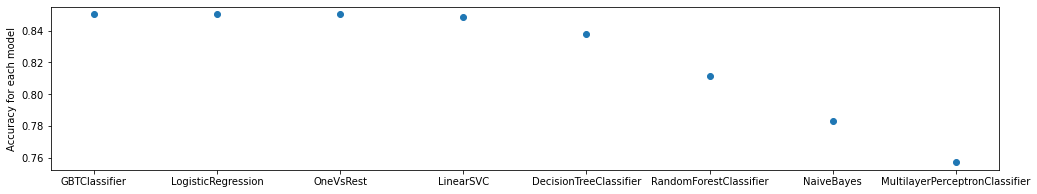

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17, 3))
plt.plot(sorted_modelAccuracy.keys(),sorted_modelAccuracy.values(),'o')
plt.ylabel("Accuracy for each model")
plt.show()

As we can see from the plot above, the model with the highest accuracy is GBTClassifier. My assumption is that the defult hyper-paramiters are the best for each model. Therefor, to avoid unfair paramiters, I set only minimum hypr-paramiters and left as much defult as possible.